# Lattice Validation Dashboard

This notebook lives alongside the module-level checks in `python/validation`. Run `make lattice-data` (or `make all`) from this directory to refresh the JSON artifacts under `python/validation/artifacts/lattice_data/`, then execute the cells below to inspect them.


In [3]:
from pathlib import Path
import json
import pandas as pd
import numpy as np

NOTEBOOK_DIR = Path.cwd()
DATA_DIR = NOTEBOOK_DIR / "artifacts" / "lattice_data"
print(f"Reading lattice reports from {DATA_DIR}")

def load_reports():
    reports = []
    for path in sorted(DATA_DIR.glob("lattice_*.json")):
        with path.open() as fp:
            payload = json.load(fp)
        payload["artifact_path"] = path
        reports.append(payload)
    if not reports:
        raise FileNotFoundError(
            "No lattice validation JSON artifacts present. Run make lattice-data first."
        )
    return reports

reports = load_reports()
summary = pd.DataFrame({
    "lattice": [r["lattice"] for r in reports],
    "scale_a": [r["scale_a"] for r in reports],
    "classification": [r["classification"] for r in reports],
    "cell_area": [r["cell_area"] for r in reports],
    "reciprocal_area": [r["reciprocal_area"] for r in reports],
    "max_abs_error": [r["validation"]["max_abs_error"] for r in reports],
    "tolerance": [r["validation"]["tolerance"] for r in reports],
    "passed": [r["validation"]["passed"] for r in reports],
})
summary

Reading lattice reports from /home/renlephy/mpb-gpu-2D/python/validation/artifacts/lattice_data


,lattice,scale_a,classification,cell_area,reciprocal_area,max_abs_error,tolerance,passed
0,square,1.0,Square,1.000000,39.478418,0.0,1.000000e-09,True
1,triangular,1.0,Triangular,0.866025,45.585750,0.0,1.000000e-09,True


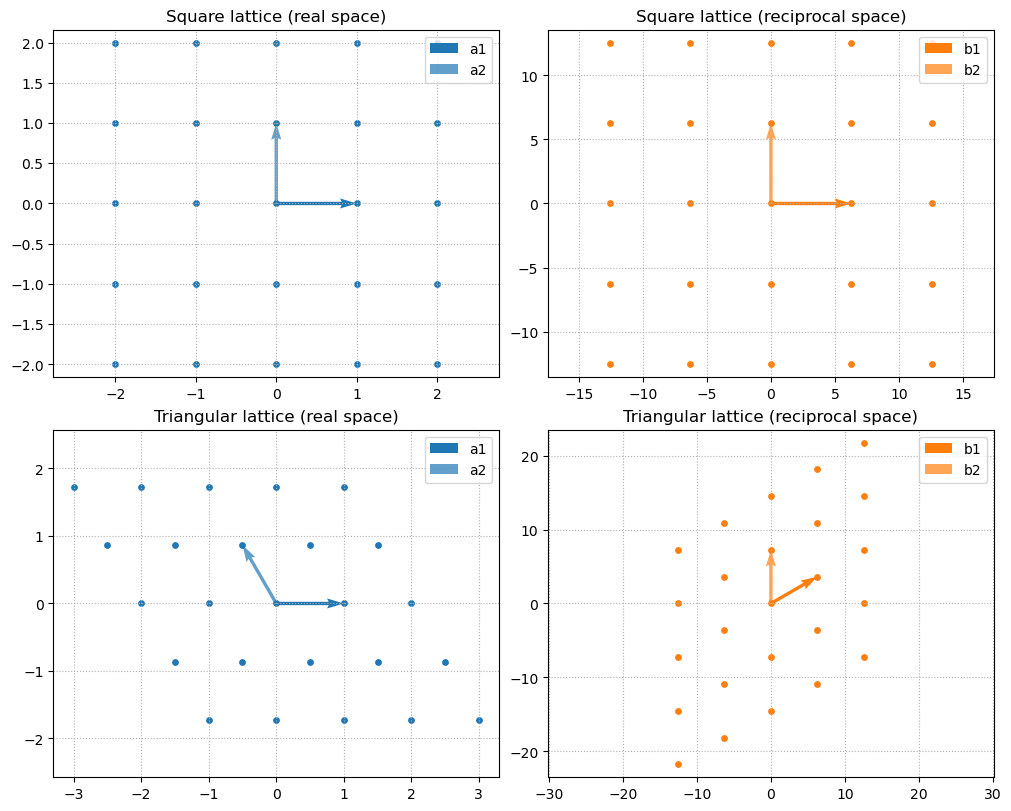

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def sample_lattice_points(v1, v2, span=2):
    grid = []
    for i in range(-span, span + 1):
        for j in range(-span, span + 1):
            grid.append(i * v1 + j * v2)
    return np.array(grid)

fig, axes = plt.subplots(len(reports), 2, figsize=(10, 4 * len(reports)), constrained_layout=True)
if len(reports) == 1:
    axes = np.array([axes])

for row_axes, report in zip(axes, reports):
    real = np.array([report['real_space']['v1'], report['real_space']['v2']])
    recip = np.array([report['reciprocal_space']['v1'], report['reciprocal_space']['v2']])
    real_points = sample_lattice_points(real[0], real[1])
    recip_points = sample_lattice_points(recip[0], recip[1])
    real_ax, recip_ax = row_axes

    real_ax.scatter(real_points[:, 0], real_points[:, 1], s=15, color='tab:blue')
    real_ax.quiver(0, 0, real[0][0], real[0][1], angles='xy', scale_units='xy', scale=1, color='tab:blue', label='a1')
    real_ax.quiver(0, 0, real[1][0], real[1][1], angles='xy', scale_units='xy', scale=1, color='tab:blue', alpha=0.7, label='a2')
    real_ax.set_aspect('equal', adjustable='datalim')
    real_ax.set_title(f"{report['lattice'].title()} lattice (real space)")
    real_ax.grid(True, linestyle=':')
    real_ax.legend(loc='upper right')

    recip_ax.scatter(recip_points[:, 0], recip_points[:, 1], s=15, color='tab:orange')
    recip_ax.quiver(0, 0, recip[0][0], recip[0][1], angles='xy', scale_units='xy', scale=1, color='tab:orange', label='b1')
    recip_ax.quiver(0, 0, recip[1][0], recip[1][1], angles='xy', scale_units='xy', scale=1, color='tab:orange', alpha=0.7, label='b2')
    recip_ax.set_aspect('equal', adjustable='datalim')
    recip_ax.set_title(f"{report['lattice'].title()} lattice (reciprocal space)")
    recip_ax.grid(True, linestyle=':')
    recip_ax.legend(loc='upper right')

plt.show()